# Tomographic Measurements

Circuit

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, Gate
from qiskit.visualization import circuit_drawer
import numpy as np

# Define the reference states initialization
def initialize_reference_states(qc):
    # |0⟩ state on qubit 0
    qc.ry(0, 0)
    qc.rz(0, 0)

    # |1⟩ state on qubit 1
    qc.ry(np.pi, 1)
    qc.rz(0, 1)

    # |+⟩ state on qubit 2
    qc.ry(np.pi/2, 2)
    qc.rz(0, 2)

    # |−⟩ state on qubit 3
    qc.ry(-np.pi/2, 3)
    qc.rz(0, 3)

    # |+i⟩ state on qubit 4
    qc.ry(np.pi/2, 4)
    qc.rz(np.pi/2, 4)

    # |-i⟩ state on qubit 5
    qc.ry(-np.pi/2, 5)
    qc.rz(np.pi/2, 5)


# Create a 6-qubit quantum circuit
circuit = QuantumCircuit(6)

# Initialize the reference states
initialize_reference_states(circuit)

# Apply the same unitary to all 6 qubits
circuit.barrier()  # Add a barrier for clarity in the visualization
for qubit in range(6):
    circuit.x(qubit)
    
circuit.barrier()
def create_custom_gate():
    custom_gate = Gate('M', 1, [])
    return custom_gate

# Apply the custom gate 'M' to all qubits
custom_gate = create_custom_gate()
for qubit in range(6):
    circuit.append(custom_gate, [qubit])

# Draw the circuit
circuit.measure_all()
fig = circuit.draw(output='mpl')  # Use Matplotlib to draw the circuit
fig.savefig('quantum_circuit.png')  # Save the figure to a file


Collecting the tomographic measurements

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Define the reference circuits for each state
def create_reference_circuits():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Pauli-X variational circuit
variational_circuit_x = QuantumCircuit(1)
variational_circuit_x.x(0)

# Function to combine reference and variational circuits
def combine_circuits(reference_circuit, variational_circuit):
    combined_circuit = reference_circuit.compose(variational_circuit, inplace=False)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1024).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Function to produce measurements and put them in a matrix
def produce_measurements_pauli_x():
    measurements_matrix = []

    reference_circuits = create_reference_circuits()

    # Iterate over the reference circuits
    for reference_circuit in reference_circuits:
        # Combine the reference circuit with the Pauli-X gate circuit
        combined_circuit = combine_circuits(reference_circuit, variational_circuit_x)
        
        # Measure the combined circuit in each basis
        prob_z = get_probabilities(measure_circuit(combined_circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(combined_circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(combined_circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append measurements for the current reference circuit
        measurements_matrix.append(measured_probabilities)

    return np.array(measurements_matrix)

# Produce and print measurements for the Pauli-X circuit
measurements_matrix_x = produce_measurements_pauli_x()
print("Measurements matrix for Pauli-X gate:")
print(measurements_matrix_x)


Measurements matrix for Pauli-X gate:
[[0.         1.         0.4921875  0.5078125  0.49902344 0.50097656]
 [1.         0.         0.49609375 0.50390625 0.50585938 0.49414062]
 [0.48828125 0.51171875 1.         0.         0.50390625 0.49609375]
 [0.52050781 0.47949219 0.         1.         0.49707031 0.50292969]
 [0.51855469 0.48144531 0.49511719 0.50488281 0.         1.        ]
 [0.48828125 0.51171875 0.51660156 0.48339844 1.         0.        ]]


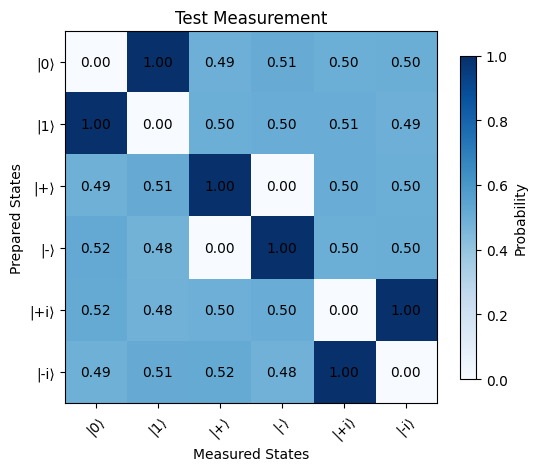

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Convert matrix to numpy array
Tomographic_measurements = measurements_matrix_x

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))
heatmap = ax.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax.set_title('Test Measurement')
ax.set_xticks(np.arange(len(state_labels)))
ax.set_yticks(np.arange(len(state_labels)))
ax.set_xticklabels(state_labels, rotation=45)
ax.set_yticklabels(state_labels)
ax.set_xlabel('Measured States')
ax.set_ylabel('Prepared States')

# Add text annotations
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar
plt.colorbar(heatmap, ax=ax, label='Probability', shrink=0.7)

# Save the plot
plt.savefig('Test_Measurements_Heatmap.png',dpi=100)

# Show the plot
plt.show()


# Variational Circuit

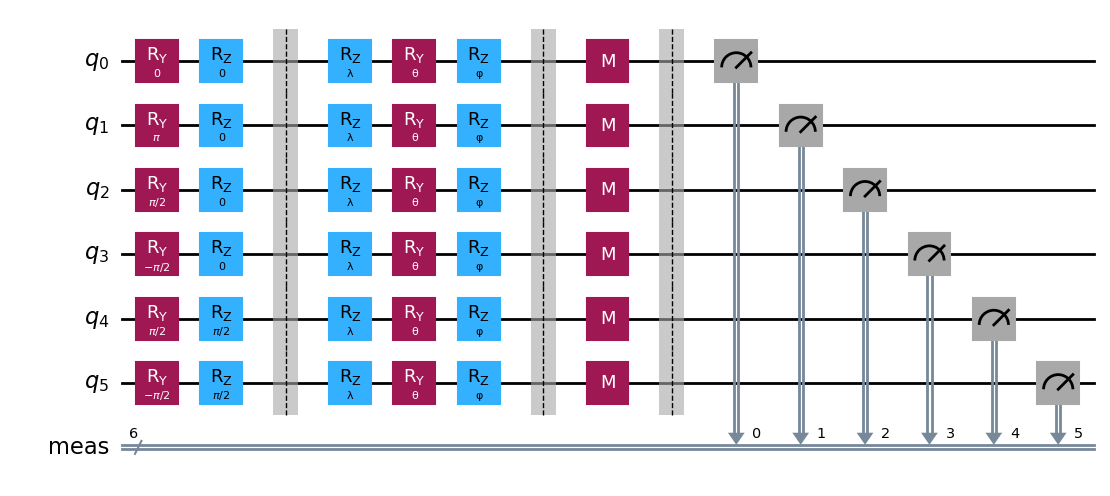

In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, Gate
from qiskit.visualization import circuit_drawer
import numpy as np

# Define the reference states initialization
def initialize_reference_states(qc):
    # |0⟩ state on qubit 0
    qc.ry(0, 0)
    qc.rz(0, 0)

    # |1⟩ state on qubit 1
    qc.ry(np.pi, 1)
    qc.rz(0, 1)

    # |+⟩ state on qubit 2
    qc.ry(np.pi/2, 2)
    qc.rz(0, 2)

    # |−⟩ state on qubit 3
    qc.ry(-np.pi/2, 3)
    qc.rz(0, 3)

    # |+i⟩ state on qubit 4
    qc.ry(np.pi/2, 4)
    qc.rz(np.pi/2, 4)

    # |-i⟩ state on qubit 5
    qc.ry(-np.pi/2, 5)
    qc.rz(np.pi/2, 5)

# Define parameters for the unitary
theta = Parameter('θ')
phi = Parameter('φ')
Lambda = Parameter('λ')

# Create a 6-qubit quantum circuit
circuit = QuantumCircuit(6)

# Initialize the reference states
initialize_reference_states(circuit)

# Apply the same unitary to all 6 qubits
circuit.barrier()  # Add a barrier for clarity in the visualization
for qubit in range(6):
    circuit.rz(Lambda, qubit)
    circuit.ry(theta, qubit)
    circuit.rz(phi, qubit)

# Define the custom gate 'M'
# For demonstration, use an identity gate (you can replace this with your own gate implementation)
circuit.barrier()
def create_custom_gate():
    custom_gate = Gate('M', 1, [])
    return custom_gate

# Apply the custom gate 'M' to all qubits
custom_gate = create_custom_gate()
for qubit in range(6):
    circuit.append(custom_gate, [qubit])

# Draw the circuit
circuit.measure_all()

circuit_drawer(circuit, output='mpl')


# Cost Function

# Alternate Cost function

In [88]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the reference circuits for each state
def create_reference_circuits():
    circuits = []

    # |0⟩ state
    qc_0 = QuantumCircuit(1)
    qc_0.ry(0, 0)
    qc_0.rz(0, 0)
    circuits.append(qc_0)

    # |1⟩ state
    qc_1 = QuantumCircuit(1)
    qc_1.ry(np.pi, 0)
    qc_1.rz(0, 0)
    circuits.append(qc_1)

    # |+⟩ state
    qc_plus = QuantumCircuit(1)
    qc_plus.ry(np.pi/2, 0)
    qc_plus.rz(0, 0)
    circuits.append(qc_plus)

    # |−⟩ state
    qc_minus = QuantumCircuit(1)
    qc_minus.ry(-np.pi/2, 0)  
    qc_minus.rz(0, 0)
    circuits.append(qc_minus)

    # |+i⟩ state
    qc_plus_i = QuantumCircuit(1)
    qc_plus_i.ry(np.pi/2, 0)
    qc_plus_i.rz(np.pi/2, 0)
    circuits.append(qc_plus_i)

    # |-i⟩ state
    qc_minus_i = QuantumCircuit(1)
    qc_minus_i.ry(-np.pi/2, 0)
    qc_minus_i.rz(np.pi/2, 0)
    circuits.append(qc_minus_i)

    return circuits

# Define parameters for the variational circuit
theta = Parameter('θ')
phi = Parameter('φ')
Lambda = Parameter('λ')

# Create a variational circuit
variational_circuit = QuantumCircuit(1)
variational_circuit.rz(Lambda, 0)
variational_circuit.ry(theta, 0)
variational_circuit.rz(phi, 0)

# Function to combine reference and variational circuits
def combine_circuits(reference_circuit, variational_circuit, params):
    combined_circuit = reference_circuit.compose(variational_circuit, inplace=False)
    combined_circuit = combined_circuit.assign_parameters(params)
    return combined_circuit

# Run the circuit and return probabilities
def get_probabilities(circuit, basis):
    simulator = AerSimulator()
    compiled_circuit = transpile(circuit, simulator)
    result = simulator.run(compiled_circuit, shots=1000).result()
    counts = result.get_counts()

    # Define state labels for each basis
    state_labels = {
        'z': {'0': '|0⟩', '1': '|1⟩'},
        'x': {'0': '|+⟩', '1': '|-⟩'},
        'y': {'0': '|+i⟩', '1': '|-i⟩'}
    }

    # Map counts to state labels
    labeled_counts = {state_labels[basis].get(k, k): v for k, v in counts.items()}
    total_shots = sum(labeled_counts.values())
    probabilities = {state: count / total_shots for state, count in labeled_counts.items()}

    return probabilities

# Measure circuit in different bases
def measure_circuit(circuit, basis):
    if basis == 'z':
        circuit.measure_all()
    elif basis == 'x':
        circuit.h(0)
        circuit.measure_all()
    elif basis == 'y':
        circuit.rx(np.pi / 2, 0)
        circuit.measure_all()
    else:
        raise ValueError("Basis must be one of 'z', 'x', or 'y'")
    return circuit

# Cost function across all reference states
def cost_function(params, target_measurements, callback=None):
    reference_circuits = create_reference_circuits()

    total_cost = 0  # Initialize total cost

    for i, reference_circuit in enumerate(reference_circuits):
        circuit = combine_circuits(reference_circuit, variational_circuit, params)
        
        # Measure in each basis and get probabilities
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Calculate the cost for this reference circuit
        target_probabilities = np.array(target_measurements[i])
        cost = np.sum((measured_probabilities - target_probabilities) ** 2)
        total_cost += cost

    if callback:
        callback(params, total_cost)

    return total_cost

# Bounds constraint functions
def constraint_theta_lower(params):
    return params[0]  - (5*np.pi/6)

def constraint_theta_upper(params):
    return np.pi - params[0]  

def constraint_phi_lower(params):
    return params[1]  - (0)

def constraint_phi_upper(params):
    return np.pi/90 - params[1]  

def constraint_lambda_lower(params):
    return params[2]  - (5*np.pi/6)

def constraint_lambda_upper(params):
    return np.pi - params[2]  

# List of constraints
constraints = [
    {'type': 'ineq', 'fun': constraint_theta_lower},  
    {'type': 'ineq', 'fun': constraint_theta_upper},  
    {'type': 'ineq', 'fun': constraint_phi_lower},    
    {'type': 'ineq', 'fun': constraint_phi_upper},    
    {'type': 'ineq', 'fun': constraint_lambda_lower}, 
    {'type': 'ineq', 'fun': constraint_lambda_upper}   
]

# Initialize lists to store values
iterations = []
cost_values = []

# Callback function to update the lists
def callback_function(params, cost):
    iterations.append(len(iterations))  # Store the iteration number
    cost_values.append(cost)  # Store the cost value

target_measurements_X = measurements_matrix_x 
# Initial guess for parameters within [0, π/2]
initial_params = [5*np.pi/6, np.pi/360, 5*np.pi/6]  

result_x = minimize(cost_function, initial_params, args=(target_measurements_X, callback_function), 
                  method='COBYLA',
                    #bounds = [(5*np.pi/6, np.pi), (0, np.pi/90), (5*np.pi/6, np.pi)])
                    constraints=constraints, options={'maxiter': 100})

# Plotting sections
# Plot and save normal scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Normal Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Normal Scale Cost Function for Pauli-X operator')
plt.legend()
plt.savefig(' Nelder normal_scale_cost_function_plot.png')
plt.close()

# Plot and save log scale plot
plt.figure()
plt.plot(iterations, cost_values, label="Cost Function (Log Scale)")
plt.xlabel('Iteration')
plt.ylabel('Cost Function')
plt.title('Log Scale Cost Function for Pauli-X operator')
plt.yscale('log')
plt.legend()
plt.savefig('Nelder log_scale_cost_function_plot.png')
plt.close()

# Optimal parameters and cost
optimal_params_x = result_x.x
optimal_cost_x = result_x.fun
print("Optimal Parameters:", optimal_params_x)
print("Optimal Cost:", optimal_cost_x)

theta_opt_x, phi_opt_x, Lambda_opt_x = result_x.x
print(f"theta: {theta_opt_x}")
print(f"phi: {phi_opt_x}")
print(f"Lambda:{Lambda_opt_x}")


Optimal Parameters: [3.1414629  0.03481156 3.12593746]
Optimal Cost: 0.01723619848632814
theta: 3.1414629019821785
phi: 0.034811563385776116
Lambda:3.12593745618998


# Variational operator

In [90]:
import numpy as np

def rotation_matrix(theta, phi, lambda_):
    """
    Returns the universal rotation matrix for a single qubit using the given theta, phi, and lambda.
    """
    return np.array([
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (lambda_ + phi)) * np.cos(theta / 2)]
    ])


# Generate the rotation matrix
rotation_matrix_result_x = rotation_matrix(theta_opt_x, phi_opt_x, Lambda_opt_x)

# Print the resulting rotation matrix
print("\nUnitary Matrix, U:")
print(rotation_matrix_result_x)


Unitary Matrix, U:
[[ 6.48758038e-05+0.00000000e+00j  9.99877458e-01-1.56545579e-02j]
 [ 9.99394137e-01+3.48045327e-02j -6.48639005e-05-1.24270863e-06j]]


# Fidelity version 1

# Fidelity alternate version


Unitary Matrix, U:
[[ 6.48758038e-05+0.00000000e+00j  9.99877458e-01-1.56545579e-02j]
 [ 9.99394137e-01+3.48045327e-02j -6.48639005e-05-1.24270863e-06j]]

Fidelity with Pauli-X: 0.9993634074352221
Fidelity of Sigma-X with itself: 1.0
Error in predicted operator (Frobenius norm): 0.038168195980466724


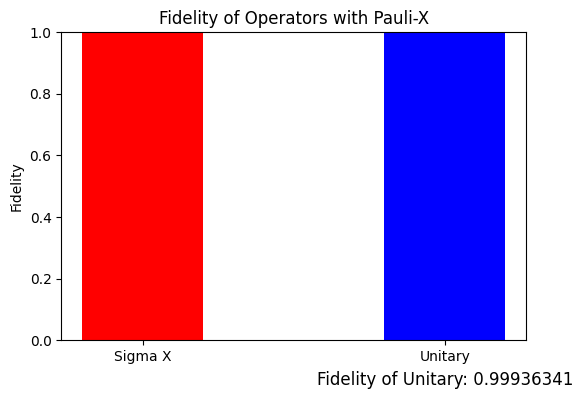

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Define the rotation matrix function
def rotation_matrix(theta, phi, lambda_):
    """
    Returns the universal rotation matrix for a single qubit using the given theta, phi, and lambda.
    """
    return np.array([
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (lambda_ + phi)) * np.cos(theta / 2)]
    ])

# Generate the rotation matrix
rotation_matrix_result_x = rotation_matrix(theta_opt_x, phi_opt_x, Lambda_opt_x)

# Actual Pauli-X operator
sigma_X = np.array([[0, 1], [1, 0]])

# Define a function to calculate fidelity
def calculate_fidelity(U, V):
    """
    Calculates the fidelity between two unitary operators U and V.
    """
    UdaggerV = np.dot(U.conj().T, V)
    fidelity = (np.abs(np.trace(UdaggerV))**2) / 4
    return fidelity

# Calculate the fidelity between our rotation matrix and Pauli-X
fidelity_unitary = calculate_fidelity(rotation_matrix_result_x, sigma_X)
fidelity_sigma_X = calculate_fidelity(sigma_X, sigma_X)  # Always 1, since it's with itself

# Calculate the error (using norm of the difference)
error = np.linalg.norm(rotation_matrix_result_x - sigma_X)

# Print results
print("\nUnitary Matrix, U:")
print(rotation_matrix_result_x)
print("\nFidelity with Pauli-X:", fidelity_unitary)
print("Fidelity of Sigma-X with itself:", fidelity_sigma_X)
print("Error in predicted operator (Frobenius norm):", error)

# Plot fidelity
labels = ['Sigma X', 'Unitary']
fidelities = [fidelity_sigma_X, fidelity_unitary]
colors = ['red', 'blue']

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, fidelities, color=colors, width=0.4)  # Set width and colors here
plt.ylim(0, 1)  # Fidelity ranges from 0 to 1
plt.ylabel('Fidelity')
plt.title('Fidelity of Operators with Pauli-X')
# Adding text below the x-axis
plt.text(1, -0.1, f'Fidelity of Unitary: {fidelity_unitary:.8f}', ha='center', va='top', fontsize=12)

plt.savefig('Fidelity_of_Operators_with_Pauli-X.png')
plt.show()


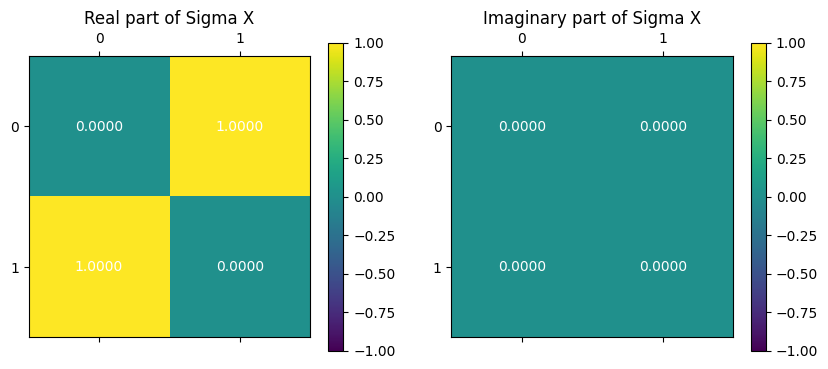

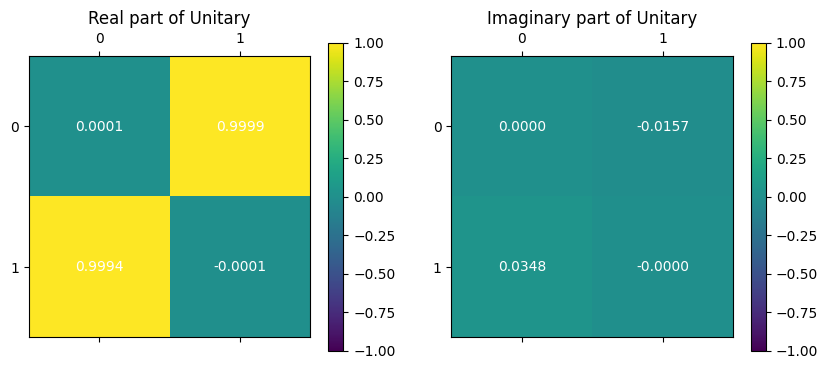

In [106]:
sigma_X = np.array([[0, 1], [1, 0]])
Unitary = np.array(rotation_matrix_result_x)

def plot_matrix(matrix, title, vmin=0, vmax=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Real part
    cax1 = ax[0].matshow(matrix.real, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=ax[0])
    ax[0].set_title(f'Real part of {title}')
    
    # Add values to the real part heatmap
    for (i, j), val in np.ndenumerate(matrix.real):
        ax[0].text(j, i, f'{val:.4f}', ha='center', va='center', color='white')
    
    # Imaginary part
    cax2 = ax[1].matshow(matrix.imag, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cax2, ax=ax[1])
    ax[1].set_title(f'Imaginary part of {title}')
    
    # Add values to the imaginary part heatmap
    for (i, j), val in np.ndenumerate(matrix.imag):
        ax[1].text(j, i, f'{val:.4f}', ha='center', va='center', color='white')
     
    plt.show()

# Plot with the desired color map limits (0 to 1)
plot_matrix(sigma_X, 'Sigma X', vmin=-1, vmax=1)
plot_matrix(Unitary, 'Unitary', vmin=-1, vmax=1)


# Measurements from the Variational Circuit

In [96]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# Function to compute Mean Squared Error (MSE) between two matrices (measured and target)
def compute_overall_mse(measured_matrix, target_matrix):
    measured_matrix = np.array(measured_matrix)
    target_matrix = np.array(target_matrix)
    return np.mean((measured_matrix - target_matrix) ** 2)

# Evaluate and store the measured probabilities in a matrix
def evaluate_measurements_matrix(optimal_params, target_measurements):
    reference_circuits = create_reference_circuits()
    measured_probabilities_matrix = []

    for i, reference_circuit in enumerate(reference_circuits):
        # Combine reference and variational circuits with optimal parameters
        circuit = combine_circuits(reference_circuit, variational_circuit, optimal_params)

        # Measure in Z, X, and Y bases
        prob_z = get_probabilities(measure_circuit(circuit.copy(), 'z'), 'z')
        prob_x = get_probabilities(measure_circuit(circuit.copy(), 'x'), 'x')
        prob_y = get_probabilities(measure_circuit(circuit.copy(), 'y'), 'y')

        # Extract probabilities for each basis
        prob_0 = prob_z.get('|0⟩', 0)
        prob_1 = prob_z.get('|1⟩', 0)
        prob_plus = prob_x.get('|+⟩', 0)
        prob_minus = prob_x.get('|-⟩', 0)
        prob_plus_i = prob_y.get('|+i⟩', 0)
        prob_minus_i = prob_y.get('|-i⟩', 0)

        # Combine all probabilities into a single list
        measured_probabilities = [prob_0, prob_1, prob_plus, prob_minus, prob_plus_i, prob_minus_i]

        # Append the list to the measured probabilities matrix
        measured_probabilities_matrix.append(measured_probabilities)

        # Print measured probabilities for clarity
        print(f"Measured Probabilities for reference state {i+1}: {measured_probabilities}")

    # Compute the overall MSE between the entire measured matrix and the target matrix
    overall_mse = compute_overall_mse(measured_probabilities_matrix, target_measurements)

    # Print the measured probability matrix and the overall MSE
    print("\nMeasured Probabilities Matrix:")
    for row in measured_probabilities_matrix:
        print(row)
    
    print(f"\nOverall Mean Squared Error (MSE): {overall_mse}")
    return measured_probabilities_matrix, overall_mse

# Now call the function with optimal_params and target_measurements

# Run the evaluation and get the measured matrix and MSE
measured_matrix, overall_mse = evaluate_measurements_matrix(optimal_params_x, target_measurements_X)


Measured Probabilities for reference state 1: [0, 1.0, 0.491, 0.509, 0.498, 0.502]
Measured Probabilities for reference state 2: [1.0, 0, 0.479, 0.521, 0.479, 0.521]
Measured Probabilities for reference state 3: [0.513, 0.487, 1.0, 0, 0.464, 0.536]
Measured Probabilities for reference state 4: [0.487, 0.513, 0.001, 0.999, 0.51, 0.49]
Measured Probabilities for reference state 5: [0.54, 0.46, 0.502, 0.498, 0, 1.0]
Measured Probabilities for reference state 6: [0.474, 0.526, 0.499, 0.501, 0.999, 0.001]

Measured Probabilities Matrix:
[0, 1.0, 0.491, 0.509, 0.498, 0.502]
[1.0, 0, 0.479, 0.521, 0.479, 0.521]
[0.513, 0.487, 1.0, 0, 0.464, 0.536]
[0.487, 0.513, 0.001, 0.999, 0.51, 0.49]
[0.54, 0.46, 0.502, 0.498, 0, 1.0]
[0.474, 0.526, 0.499, 0.501, 0.999, 0.001]

Overall Mean Squared Error (MSE): 0.0003073666246202259


In [97]:
# Lets try to print the matrices

print("The Target Measurements \n")
target_matrix = np.array(target_measurements_X)
print(target_matrix)
print("\n")
print("The Prepared Measurements \n")
Prepared_measurements = np.array(measured_matrix)
np.set_printoptions(linewidth=200)
print(Prepared_measurements)

The Target Measurements 

[[0.         1.         0.4921875  0.5078125  0.49902344 0.50097656]
 [1.         0.         0.49609375 0.50390625 0.50585938 0.49414062]
 [0.48828125 0.51171875 1.         0.         0.50390625 0.49609375]
 [0.52050781 0.47949219 0.         1.         0.49707031 0.50292969]
 [0.51855469 0.48144531 0.49511719 0.50488281 0.         1.        ]
 [0.48828125 0.51171875 0.51660156 0.48339844 1.         0.        ]]


The Prepared Measurements 

[[0.    1.    0.491 0.509 0.498 0.502]
 [1.    0.    0.479 0.521 0.479 0.521]
 [0.513 0.487 1.    0.    0.464 0.536]
 [0.487 0.513 0.001 0.999 0.51  0.49 ]
 [0.54  0.46  0.502 0.498 0.    1.   ]
 [0.474 0.526 0.499 0.501 0.999 0.001]]


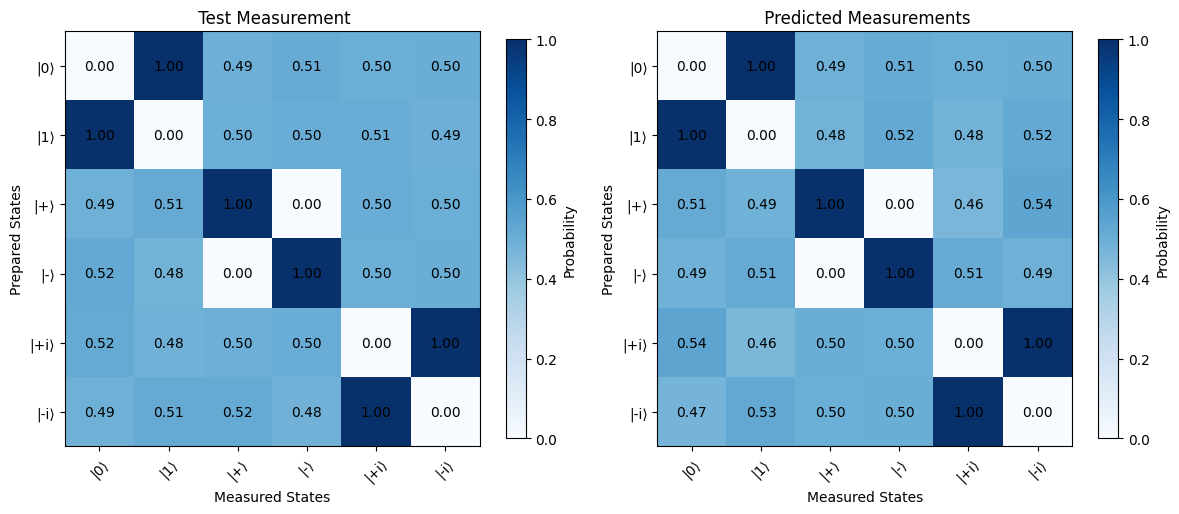

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Matrices 
Tomographic_measurements = np.array((target_matrix))
Experimental_measurements = np.array((Prepared_measurements))

# Define the state labels
state_labels = ['|0⟩', '|1⟩', '|+⟩', '|-⟩', '|+i⟩', '|-i⟩']

# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Target Measurements heatmap on the left
heatmap1 = ax1.imshow(Tomographic_measurements, cmap='Blues', interpolation='nearest')
ax1.set_title(' Test Measurement')
ax1.set_xticks(np.arange(len(state_labels)))
ax1.set_yticks(np.arange(len(state_labels)))
ax1.set_xticklabels(state_labels, rotation=45)
ax1.set_yticklabels(state_labels)
ax1.set_xlabel('Measured States')
ax1.set_ylabel('Prepared States')

# Add text annotations to the target matrix
for i in range(Tomographic_measurements.shape[0]):
    for j in range(Tomographic_measurements.shape[1]):
        value = Tomographic_measurements[i, j]
        ax1.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the target heatmap
fig.colorbar(heatmap1, ax=ax1, label='Probability',shrink= 0.7)

# Plot the Prepared Measurements heatmap on the right
heatmap2 = ax2.imshow(Experimental_measurements, cmap='Blues', interpolation='nearest')
ax2.set_title(' Predicted Measurements')
ax2.set_xticks(np.arange(len(state_labels)))
ax2.set_yticks(np.arange(len(state_labels)))
ax2.set_xticklabels(state_labels, rotation=45)
ax2.set_yticklabels(state_labels)
ax2.set_xlabel('Measured States')
ax2.set_ylabel('Prepared States')

# Add text annotations to the prepared matrix
for i in range(Experimental_measurements.shape[0]):
    for j in range(Experimental_measurements.shape[1]):
        value = Experimental_measurements[i, j]
        ax2.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')

# Add color bar for the prepared heatmap
fig.colorbar(heatmap2, ax=ax2, label='Probability',shrink= 0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()